In [1]:
import pandas as pd
import numpy as np
import os
import wikipedia
import requests
from threading import Lock

In [2]:
# %load links/utils.py
QUERY_DICT = {'Organization Founded By^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P112 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization Founded By':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P112 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                        ],
              'Organization Headquarters':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P159 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                          ],
              'Organization Subsidiary Of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P355 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                              ],
              'Organization Subsidiary Of':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P355 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                           ],
              'Organization top employees':["""SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P169 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""", # CEO
                                            """SELECT ?item ?itemLabel WHERE {
                                          wd:%s wdt:P488 ?item.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }""" # Chairperson
                                            ],
              'Person Employee or Member of^-1':["""SELECT ?item ?itemLabel WHERE {
                                          ?item wdt:P108 wd:%s.
                                          SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                        }"""
                                                ],
              'Person Employee or Member of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P108 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                            ],
              'Person Place of Birth':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P19 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                      ],
              'Person Current and Past Location of Residence':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P551 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                                              ],
              'Person Parents':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P22 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Father
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P25 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""", #Mother
                                """SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P1038 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }""" #Relative (Adopted Parents?)
                                # Shall we include stepparents??
                               ],
              'Person Parents^-1':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P40 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                  ],
              'Person Siblings':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P3373 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                                ],
              'Person Spouse':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P26 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                              ],
              'Citizen of':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P27 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                           ],
              'Educated at':["""SELECT ?item ?itemLabel WHERE {
                                              wd:%s wdt:P69 ?item.
                                              SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
                                            }"""
                            ]
             }




from SPARQLWrapper import SPARQLWrapper, JSON   
from rosette.api import API, DocumentParameters, RosetteException
import pandas as pd
import wikipedia
import requests
import numpy as np
import pickle
import random
from threading import Lock
import os, sys
import threading
from threading import Thread
import time
import queue

class Utils:
    
    def __init__(self):
        self.id_dict = {}
        self.lock = Lock()
        self.load_dict()
        
    
    def __del__(self):
        self.save_dict()

    def get_id(self, message, dict_to_use=None):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict
    
        if message in self.id_dict:
            return self.id_dict[message]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = message
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[message] = r.json()['search'][0]['id']
                return self.id_dict[message]
            except Exception:
                return -1 #The id doesn't exist


    def id_to_name(self, eid):
#         if dict_to_use:
#             dict_to_use = dict_to_use
#         else:
#             global id_dict
#             dict_to_use = id_dict

        if eid in self.id_dict.values():
            return [key for key, value in self.id_dict.items() if value == eid][0]
        else:
            API_ENDPOINT = "https://www.wikidata.org/w/api.php"
            query = eid
            params = {
                'action': 'wbsearchentities',
                'format': 'json',
                'language': 'en',
                'search': query
            }
            r = requests.get(API_ENDPOINT, params = params)
            try:
                with self.lock:
                    self.id_dict[ r.json()['search'][0]['label'] ] = r.json()['search'][0]['id']
                return r.json()['search'][0]['label']
            except Exception:
                return -1 #The id doesn't exist


    def get_results(self, query, value, endpoint_url="https://query.wikidata.org/sparql"):
        sparql = SPARQLWrapper(endpoint_url)
        sparql.setQuery(query%value)
        sparql.setReturnFormat(JSON)
        return sparql.query().convert()


    def ground_truth(self, relation, subject, debug=False):
        global QUERY_DICT
        results = []
        gt = []
        try:
            results = [self.get_results(query, self.get_id(subject)) for query in QUERY_DICT[relation]]
            for result in results:
                for r in result["results"]["bindings"]:
                    gt.append(r['itemLabel']['value'])
        except:
            if debug:
                print (relation, subject)
        return gt

    def add_ground_truth(self, df, debug=False):
        if debug:
            print (df)
        df = df.reset_index()
        df['Pseudo Ground Truth'] = df.apply(lambda row: self.ground_truth(row['Relationship'], row['Subject']), axis=1)
        df['Count_PGT'] = df['Pseudo Ground Truth'].apply(lambda x: len(x))
        df = df.set_index(['Subject','Relationship'])
        return df

    def add_recall_score(self, df):
        df['Recall Prediction'] = np.random.randint(0, 100, df.shape[0])/100
        return df


    def load_dict(self):
        try:
            with open('./id_dict.pkl', 'rb') as fp:
                self.id_dict = pickle.load(fp)
        except:
            print ("Creating a new Dictionary")
            self.id_dict = {}


    def save_dict(self):
        with self.lock:
            old_dict = self.get_dict()
            self.id_dict = {**self.id_dict, **old_dict}
            with open('./id_dict.pkl', 'wb') as fp:
                pickle.dump(self.id_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)
                print("Saved")


    def get_dict(self):
        di = {}
        with open('./id_dict.pkl', 'rb') as fp:
            di = pickle.load(fp)
        return di


    def Analyse(self, message, alt_url='https://api.rosette.com/rest/v1/'):
        """ Run the example """
        # Create an API instance
        api = API(user_key="89350904c7392a44f0f9019563be727a", service_url=alt_url)

        # Set selected API options.
        # For more information on the functionality of these
        # and other available options, see Rosette Features & Functions
        # https://developer.rosette.com/features-and-functions#morphological-analysis-introduction

        # api.set_option('modelType','perceptron') #Valid for Chinese and Japanese only

        # Opening the ID Dictionary
#         load_dict()
        ### Will Close after Analysis of the document is completed

        params = DocumentParameters()
        relationships_text_data = wikipedia.page(message).content[:20000]
        params["content"] = relationships_text_data
        rel = []
        message_id = self.get_id(message)
        message_split = message.split(" ")
        try:
            RESULT = api.relationships(params)
            #print(RESULT)
            for r in RESULT['relationships']:
                arg2_split = r['arg2'].split(" ")
                confidence = '?'
                if "confidence" in r:
                    confidence = str(round(r["confidence"],2))
                if any(s in arg2_split for s in message_split):
                    if self.get_id(r['arg2']) == message_id:
                        rel.append({'Relationship':r['predicate']+'^-1', 'Subject':r['arg2'], 'Object':r['arg1'], 'Confidence': confidence})
                rel.append({'Relationship':r['predicate'],'Subject':r['arg1'],'Object':r['arg2'], 'Confidence': confidence})

            ## Closing the ID Dict
            self.save_dict()
            ##
            return rel, message_id
        except RosetteException as exception:
            print(exception)


class HeatMaps(Thread):
    def __init__(self, lock, eid=None, name=None):
        Thread.__init__(self)
        self.q1 = queue.Queue()
        self.q2 = queue.Queue()
        self.u = Utils()
        self.lock = lock
        if name:
            self.message = name
        else:
            self.message = self.u.id_to_name(eid)
        time.sleep(0.01)
        self.start()
        
        
    def run(self):
        a = Thread(target = self.Analyse, args = ())
        b = Thread(target = self.ground_truth, args = ())
        a.start()
        b.start()
        a.join()
        b.join()
        self.matrix_block()


    def Analyse(self):
        """ Run the example """
        # Create an API instance
        api = API(user_key="89350904c7392a44f0f9019563be727a", service_url='https://api.rosette.com/rest/v1/')
#         u = Utils()
        params = DocumentParameters()
        relationships_text_data = wikipedia.page(self.message).content[:20000]
        params["content"] = relationships_text_data
        rel = []
        message_id = self.u.get_id(self.message)
        message_split = self.message.split(" ")
        pred_list = []
        try:
            RESULT = []
            with self.lock:
                RESULT = api.relationships(params)
                
            for r in RESULT['relationships']:
                if r['predicate'] == 'Educated at':
                    arg_split = r['arg1'].split(" ")
                    if any(s in arg_split for s in message_split):
                        if self.u.get_id(r['arg1']) == message_id:
                            pred_list.append(r['arg2'])
                            
            self.q1.put(set(pred_list))
        except RosetteException as exception:
            print(exception)


    def ground_truth(self):
#         u = Utils()
        pgt = set(self.u.ground_truth('Educated at', self.message))
        self.q2.put(pgt)
    
    
    def matrix_block(self):
        q1 = self.q1.get()
        q2 = self.q2.get()
        #print(self.message, q1)
        #print(self.message, q2)
        self.tp = len(q2)
        q1 = [self.u.get_id(i) for i in q1]
        q2 = [self.u.get_id(i) for i in q2]
        #print(self.message, q1)
        #print(self.message, q2)
        count = 0
        for i in q1:
            if i in q2:
                count += 1
        self.found = count

    def get_values(self):
        return [self.found, self.tp]
    




In [3]:
df = pd.read_csv("./entity_education.tsv", sep='\t', header=None, names=['EntityID', 'EntityName', 'Count', 'EducatedAt'])

pd.set_option('display.max_colwidth', -1)
df.head(2)

In [7]:
matrix = np.zeros([10,10]) ## The HeatMap
lock = Lock() ## Shared Lock
n = 5
topN_entities = list(df['EntityID'][:n])

### Creating threads for each Entity
threads = []
for i in topN_entities:
    threads.append( HeatMaps(lock, eid=i) )

### Waiting for each thread to complete
for t in threads:
    t.join()

### Filling up the HeatMap
for t in threads:
    r,c = t.get_values()
    r = max(r-1,0)
    c = max(c-1,0)
    print(r,c)
    matrix[ r, c] += 1

Saved
0 6
0 0
0 0
0 3
0 1


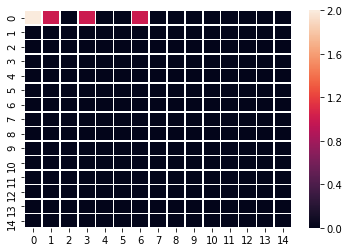

In [20]:
import seaborn as sns

fig = sns.heatmap(matrix, linewidth=0.5)

fig.get_figure().savefig("heat.png")